<a href="https://colab.research.google.com/github/pdh21/OCF_PVmapper/blob/main/DeepNet_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://avatars.githubusercontent.com/u/48357542?s=200&v=4)

## PV mapping Example:
[Peter Hurley](http://pdh21.github.io/) 

In this notebook, we will give a simple example of training a deep net to detect solar panels from remote sensing data. 

As with most neural net projects, we need to:
1. Define training data: input tensors and target tensors. (see this [notebook](https://github.com/pdh21/OCF_PVmapper/blob/main/Example_DeepNet.ipynb) to follow converting cutouts to Tensorflow record format)
2. Define a network of layers (or model ) that maps inputs to targets.
3. Configure the learning process by choosing a loss function, an optimizer
some metrics to monitor.
4. Iterate on training data by calling the fit() method of your model.

In [1]:
from google.colab import auth
auth.authenticate_user()
project_id = 'ocf-pvmapping'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://cutouts/


In [2]:
import os, sys, math
import numpy as np
import re

from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

## 
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

FILE_PATTERN='./*aerial*.tif'
OUTPUT = './cutouts_tfrecords/'  # prefix for output file names
TARGET_SIZE = [80,80]

SHARDS = 16


Tensorflow version 2.4.1
Running on TPU  ['10.63.218.90:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.63.218.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.63.218.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Read  from TFRecord Dataset

In [3]:
def read_tfrecord(example):
    features = {
        "image_aerial": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "image_binary": tf.io.FixedLenFeature([], tf.string),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "num":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers

    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    
    label  = example['label']
    num = example['num']
    height = example['size'][0]
    width  = example['size'][1]

    image_aerial = tf.image.decode_png(example['image_aerial'],channels=3)
    image_aerial = tf.reshape(image_aerial, [*TARGET_SIZE, 3])
    image_binary = tf.image.decode_png(example['image_binary'],channels=1)
    image_binary = tf.reshape(image_binary, [*TARGET_SIZE, 1])
    
    

    return image_aerial,image_binary, label, num, height, width
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False



In [4]:
#batch_size = 16 * tpu_strategy.num_replicas_in_sync
batch_size=16
validation_split = 0.19

gcs_pattern = 'gs://cutouts/'
filenames = tf.io.gfile.glob(gcs_pattern + "*.tfrec")
split = len(filenames) - int(len(filenames) * validation_split)
train_fns = filenames[:split]
validation_fns = filenames[split:]

In [5]:
def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  records = records.with_options(option_no_order)
  return records.map(read_tfrecord, num_parallel_calls=AUTO)

In [6]:
train_dataset = load_dataset(train_fns).batch(batch_size,drop_remainder=True).prefetch(AUTO)
validation_dataset = load_dataset(validation_fns).batch(batch_size, drop_remainder=True).prefetch(AUTO)

In [7]:
def display_9_images_from_dataset(dataset,batch=1):
  fig,axes=plt.subplots(9,2,figsize=(10,30))
  for i, (image_aerial,image_binary,label,num, height, width) in enumerate(dataset):
    axes[i,0].imshow(image_aerial.numpy().astype(np.uint8)[batch,...])
    axes[i,1].imshow(image_binary.numpy().astype(np.uint8)[batch,:,:,0])
    #axes[i,0].set_title(label[batch].numpy().decode("utf-8")+' '+num, fontsize=16)
    if i==8:
      break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.5, hspace=0.5)
  plt.show()

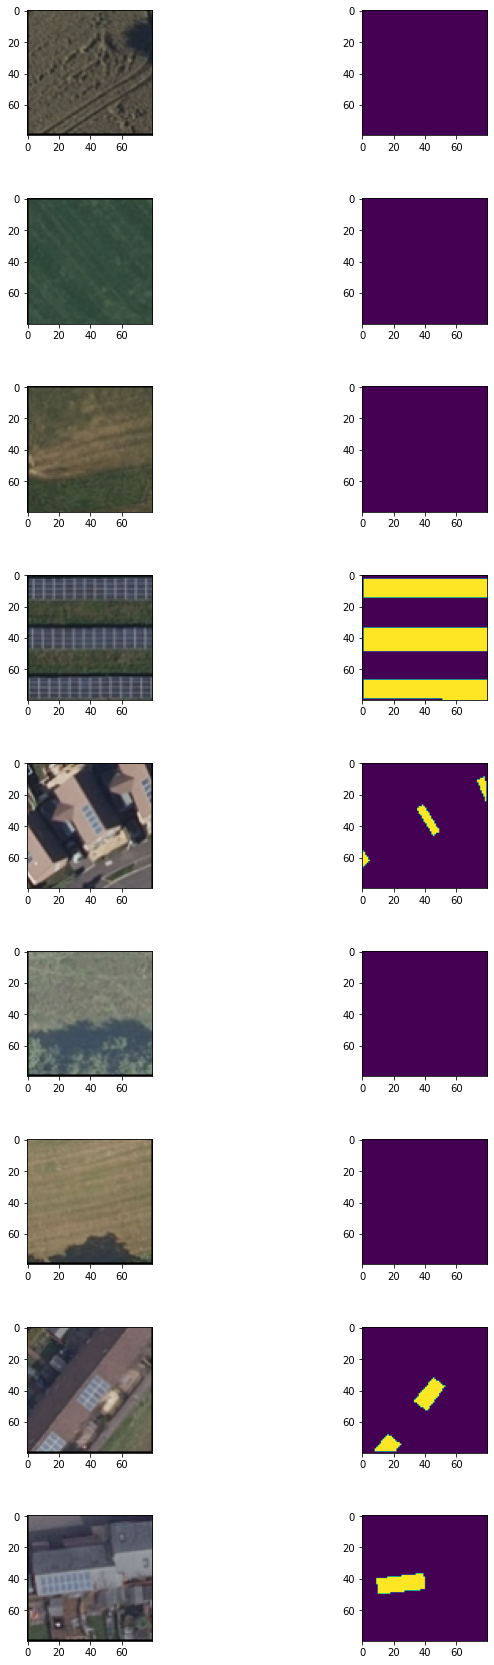

In [8]:
display_9_images_from_dataset(train_dataset)

## Model

Example Image segmentation from [Keras](https://keras.io/examples/vision/oxford_pets_image_segmentation/) using Perpare U-Net Xception-style model


In [26]:
from tensorflow.keras import layers
import keras

img_size = tuple(TARGET_SIZE)
print(img_size)
num_classes = 1

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = get_model(img_size, num_classes)
model.summary()

(80, 80)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 40, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 40, 40, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 40, 40, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________________

## Training

Calculate the number of images in each dataset. Rather than actually load the data to do so (expensive), we rely on hints in the filename. This is used to calculate the number of batches per epoch.

In [27]:
def count_data_items(filenames):
  # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
  n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
  return np.sum(n)

n_train = count_data_items(train_fns)
n_valid = count_data_items(validation_fns)
train_steps = count_data_items(train_fns) // batch_size
print("TRAINING IMAGES: ", n_train, ", STEPS PER EPOCH: ", train_steps)
print("VALIDATION IMAGES: ", n_valid)

TRAINING IMAGES:  3250 , STEPS PER EPOCH:  203
VALIDATION IMAGES:  749


In [28]:
def get_data(image_aerial,image_binary, label, num, height, width):
  return image_aerial,image_binary

In [29]:
train_gen = train_dataset.map(get_data)
val_gen = validation_dataset.map(get_data)

In [32]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="adam", loss="binary_crossentropy",metrics=['acc','AUC','Recall','Precision'])

callbacks = [
    keras.callbacks.ModelCheckpoint("gs://cutouts/", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 25
history=model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/25
203/203 [==============================] - 28s 61ms/step - loss: 0.4169 - acc: 0.9203 - auc: 0.8860 - recall: 0.6582 - precision: 0.7088 - val_loss: 0.3774 - val_acc: 0.8737 - val_auc: 0.6282 - val_recall: 0.0209 - val_precision: 0.6218
INFO:tensorflow:Assets written to: gs://cutouts/assets


INFO:tensorflow:Assets written to: gs://cutouts/assets


Epoch 2/25
203/203 [==============================] - 9s 41ms/step - loss: 0.0844 - acc: 0.9679 - auc: 0.9881 - recall: 0.8538 - precision: 0.8972 - val_loss: 0.1704 - val_acc: 0.9264 - val_auc: 0.9792 - val_recall: 0.4235 - val_precision: 0.9846
INFO:tensorflow:Assets written to: gs://cutouts/assets


INFO:tensorflow:Assets written to: gs://cutouts/assets


Epoch 3/25
203/203 [==============================] - 9s 41ms/step - loss: 0.0703 - acc: 0.9734 - auc: 0.9913 - recall: 0.8749 - precision: 0.9133 - val_loss: 0.0686 - val_acc: 0.9738 - val_auc: 0.9929 - val_recall: 0.8575 - val_precision: 0.9329
INFO:tensorflow:Assets written to: gs://cutouts/assets


INFO:tensorflow:Assets written to: gs://cutouts/assets


Epoch 4/25
203/203 [==============================] - 8s 40ms/step - loss: 0.0593 - acc: 0.9771 - auc: 0.9941 - recall: 0.8995 - precision: 0.9230 - val_loss: 0.0664 - val_acc: 0.9753 - val_auc: 0.9918 - val_recall: 0.8869 - val_precision: 0.9168
INFO:tensorflow:Assets written to: gs://cutouts/assets


INFO:tensorflow:Assets written to: gs://cutouts/assets


Epoch 5/25
203/203 [==============================] - 9s 42ms/step - loss: 0.0545 - acc: 0.9794 - auc: 0.9948 - recall: 0.9104 - precision: 0.9304 - val_loss: 0.0699 - val_acc: 0.9745 - val_auc: 0.9936 - val_recall: 0.9198 - val_precision: 0.8830
Epoch 6/25
203/203 [==============================] - 9s 41ms/step - loss: 0.0560 - acc: 0.9786 - auc: 0.9947 - recall: 0.9081 - precision: 0.9288 - val_loss: 0.0554 - val_acc: 0.9782 - val_auc: 0.9951 - val_recall: 0.8826 - val_precision: 0.9439
INFO:tensorflow:Assets written to: gs://cutouts/assets


INFO:tensorflow:Assets written to: gs://cutouts/assets


Epoch 7/25
203/203 [==============================] - 9s 44ms/step - loss: 0.0478 - acc: 0.9816 - auc: 0.9962 - recall: 0.9217 - precision: 0.9337 - val_loss: 0.0603 - val_acc: 0.9768 - val_auc: 0.9949 - val_recall: 0.8620 - val_precision: 0.9526
Epoch 8/25
203/203 [==============================] - 9s 41ms/step - loss: 0.0427 - acc: 0.9832 - auc: 0.9969 - recall: 0.9289 - precision: 0.9429 - val_loss: 0.0558 - val_acc: 0.9785 - val_auc: 0.9948 - val_recall: 0.8743 - val_precision: 0.9528
Epoch 9/25
203/203 [==============================] - 9s 42ms/step - loss: 0.0411 - acc: 0.9839 - auc: 0.9972 - recall: 0.9321 - precision: 0.9422 - val_loss: 0.0511 - val_acc: 0.9801 - val_auc: 0.9957 - val_recall: 0.9155 - val_precision: 0.9276
INFO:tensorflow:Assets written to: gs://cutouts/assets


INFO:tensorflow:Assets written to: gs://cutouts/assets


Epoch 10/25
203/203 [==============================] - 9s 41ms/step - loss: 0.0421 - acc: 0.9835 - auc: 0.9971 - recall: 0.9355 - precision: 0.9433 - val_loss: 0.0588 - val_acc: 0.9772 - val_auc: 0.9945 - val_recall: 0.8871 - val_precision: 0.9324
Epoch 11/25
203/203 [==============================] - 9s 41ms/step - loss: 0.0361 - acc: 0.9857 - auc: 0.9977 - recall: 0.9429 - precision: 0.9466 - val_loss: 0.0543 - val_acc: 0.9787 - val_auc: 0.9953 - val_recall: 0.8684 - val_precision: 0.9620
Epoch 12/25
203/203 [==============================] - 9s 41ms/step - loss: 0.0333 - acc: 0.9867 - auc: 0.9980 - recall: 0.9442 - precision: 0.9524 - val_loss: 0.0590 - val_acc: 0.9778 - val_auc: 0.9934 - val_recall: 0.8828 - val_precision: 0.9405
Epoch 13/25
203/203 [==============================] - 9s 41ms/step - loss: 0.0349 - acc: 0.9862 - auc: 0.9980 - recall: 0.9431 - precision: 0.9517 - val_loss: 0.0493 - val_acc: 0.9814 - val_auc: 0.9959 - val_recall: 0.9269 - val_precision: 0.9282
INFO:ten

INFO:tensorflow:Assets written to: gs://cutouts/assets


Epoch 14/25
203/203 [==============================] - 9s 44ms/step - loss: 0.0329 - acc: 0.9869 - auc: 0.9982 - recall: 0.9468 - precision: 0.9517 - val_loss: 0.0502 - val_acc: 0.9812 - val_auc: 0.9956 - val_recall: 0.9188 - val_precision: 0.9327
Epoch 15/25
203/203 [==============================] - 9s 42ms/step - loss: 0.0307 - acc: 0.9879 - auc: 0.9983 - recall: 0.9524 - precision: 0.9540 - val_loss: 0.0499 - val_acc: 0.9813 - val_auc: 0.9955 - val_recall: 0.9231 - val_precision: 0.9309
Epoch 16/25
203/203 [==============================] - 9s 42ms/step - loss: 0.0306 - acc: 0.9879 - auc: 0.9984 - recall: 0.9512 - precision: 0.9551 - val_loss: 0.0512 - val_acc: 0.9808 - val_auc: 0.9954 - val_recall: 0.9352 - val_precision: 0.9157
Epoch 17/25
203/203 [==============================] - 9s 42ms/step - loss: 0.0316 - acc: 0.9876 - auc: 0.9982 - recall: 0.9498 - precision: 0.9537 - val_loss: 0.0624 - val_acc: 0.9788 - val_auc: 0.9925 - val_recall: 0.9242 - val_precision: 0.9122
Epoch 18

INFO:tensorflow:Assets written to: gs://cutouts/assets


Epoch 22/25
203/203 [==============================] - 9s 42ms/step - loss: 0.0265 - acc: 0.9894 - auc: 0.9987 - recall: 0.9579 - precision: 0.9615 - val_loss: 0.0509 - val_acc: 0.9828 - val_auc: 0.9933 - val_recall: 0.9185 - val_precision: 0.9457
Epoch 23/25
203/203 [==============================] - 8s 41ms/step - loss: 0.0252 - acc: 0.9900 - auc: 0.9988 - recall: 0.9608 - precision: 0.9630 - val_loss: 0.0480 - val_acc: 0.9825 - val_auc: 0.9959 - val_recall: 0.9463 - val_precision: 0.9187
Epoch 24/25
203/203 [==============================] - 9s 42ms/step - loss: 0.0255 - acc: 0.9898 - auc: 0.9988 - recall: 0.9609 - precision: 0.9615 - val_loss: 0.0543 - val_acc: 0.9806 - val_auc: 0.9939 - val_recall: 0.9150 - val_precision: 0.9314
Epoch 25/25
203/203 [==============================] - 9s 42ms/step - loss: 0.0317 - acc: 0.9876 - auc: 0.9980 - recall: 0.9497 - precision: 0.9554 - val_loss: 0.0522 - val_acc: 0.9828 - val_auc: 0.9927 - val_recall: 0.9147 - val_precision: 0.9493


Text(0, 0.5, 'Loss')

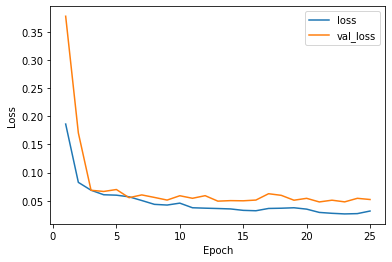

In [33]:
plt.plot(np.arange(1,epochs+1),history.history['loss'],label='loss')
plt.plot(np.arange(1,epochs+1),history.history['val_loss'],label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

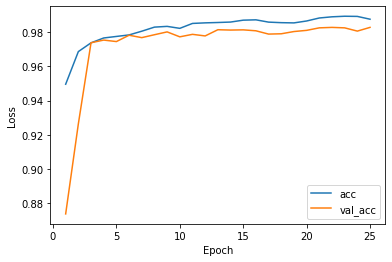

In [34]:
plt.plot(np.arange(1,epochs+1),history.history['acc'],label='acc')
plt.plot(np.arange(1,epochs+1),history.history['val_acc'],label='val_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

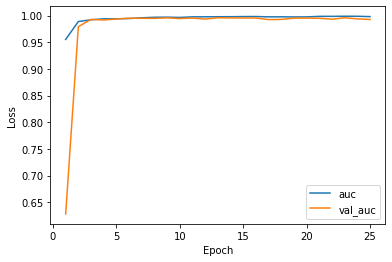

In [35]:
plt.plot(np.arange(1,epochs+1),history.history['auc'],label='auc')
plt.plot(np.arange(1,epochs+1),history.history['val_auc'],label='val_auc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

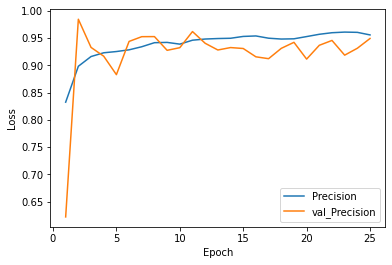

In [37]:
plt.plot(np.arange(1,epochs+1),history.history['precision'],label='Precision')
plt.plot(np.arange(1,epochs+1),history.history['val_precision'],label='val_Precision')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

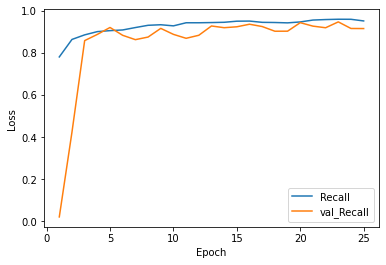

In [38]:
plt.plot(np.arange(1,epochs+1),history.history['recall'],label='Recall')
plt.plot(np.arange(1,epochs+1),history.history['val_recall'],label='val_Recall')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Visualise Predictions
Use validation set to compare predictions

In [44]:
def display_batch_images_and_preds(dataset,batch=2):
  import matplotlib.cm as cm
  my_cmap = cm.viridis
  my_cmap.set_under('k', alpha=0)
  fig,axes=plt.subplots(20,3,figsize=(10,60))
  for i, (image_aerial,image_binary) in enumerate(dataset):
    axes[i,0].imshow(image_aerial.numpy().astype(np.uint8)[batch,...])
    axes[i,1].imshow(image_binary.numpy().astype(np.uint8)[batch,:,:,0])
    val_preds=model.predict(image_aerial)
    #mask = np.argmax(val_preds[batch,:,:,:], axis=-1)
    #mask = np.expand_dims(mask, axis=-1)
    axes[i,2].imshow(image_aerial.numpy().astype(np.uint8)[batch,...])
    axes[i,2].imshow(val_preds[batch,:,:,0],alpha=0.5,cmap=my_cmap, clim=[0.3, 1])
    #axes[i,0].set_title(label[batch].numpy().decode("utf-8")+' '+num, fontsize=16)
    if i==19:
      break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.5, hspace=0.5)
  plt.show()

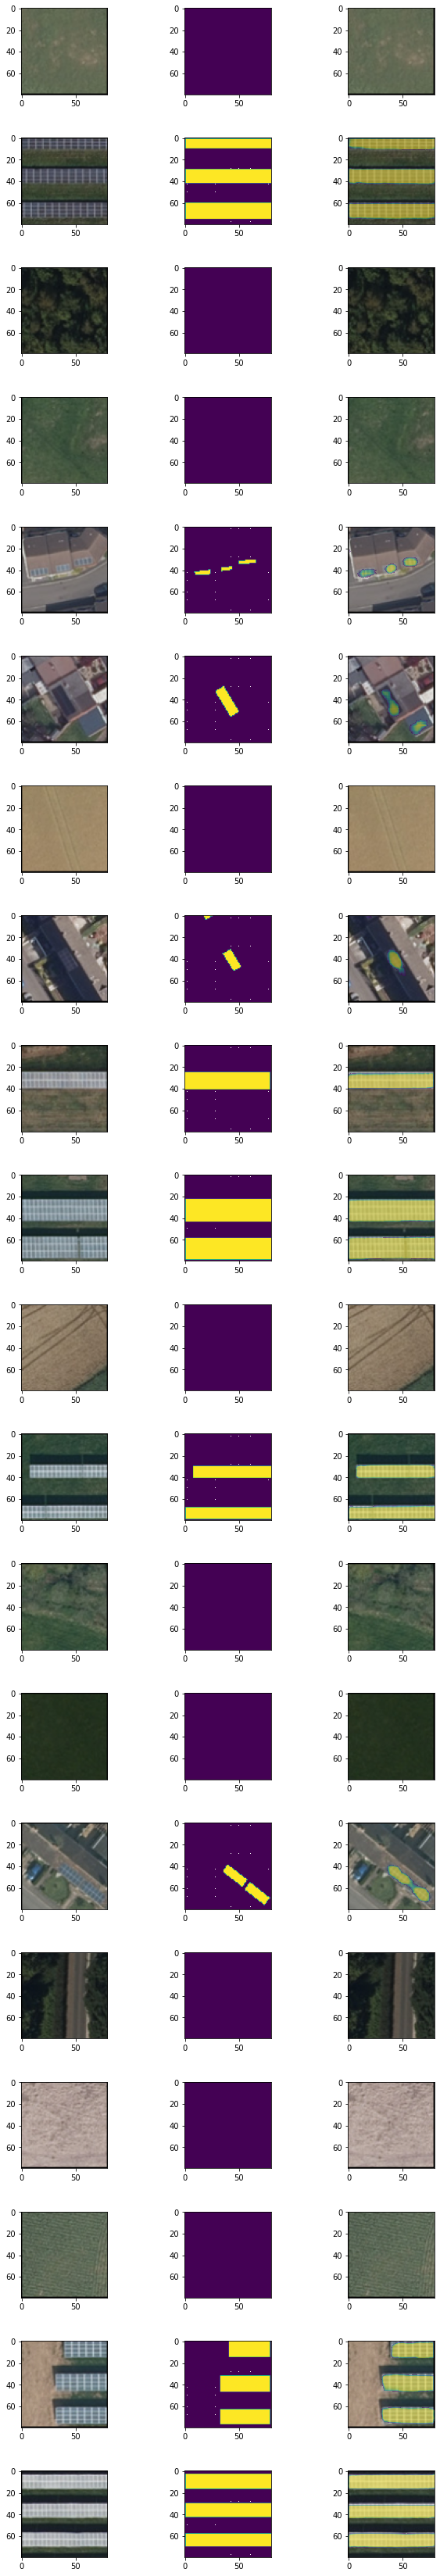

In [48]:
display_batch_images_and_preds(val_gen,batch=7)